<a href="https://colab.research.google.com/github/SamHSlva/BasicMachineLearningPytorch/blob/main/Basic_Implementations_002_CNN_MNIST_CIFAR10_100_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [98]:
class ConvNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ConvNet, self).__init__()
        self.cnn = nn.Sequential( 
                                  # Conv Layer block 1
                                  nn.Conv2d(in_channels=input_size, out_channels=input_size*10, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(input_size*10),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channels=input_size*10, out_channels=input_size*20, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),

                                  # Conv Layer block 2
                                  nn.Conv2d(in_channels=input_size*20, out_channels=input_size*40, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(input_size*40),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channels=input_size*40, out_channels=input_size*40, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Dropout2d(p=0.05),

                                  # Conv Layer block 3
                                  nn.Conv2d(in_channels=input_size*40, out_channels=input_size*80, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(input_size*80),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(in_channels=input_size*80, out_channels=input_size*80, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.AvgPool2d(kernel_size=2, stride=2),
                                  nn.Flatten()
                                 )
        
        self.fc  = nn.Sequential(nn.Linear(hidden_size, hidden_size//2), ## A first linear layer that gets an input of input_size, and generate an output half the size.
                                nn.ReLU(inplace=True), ## Activation Function introduces a Nonlinearity in the model
                                nn.Dropout(p=0.3),
                                
                                nn.Linear(hidden_size//2, hidden_size//2),
                                nn.ReLU(inplace=True),
                                
                                nn.Dropout(p=0.3),
                                nn.Linear(hidden_size//2, hidden_size//4),
                                nn.ReLU(inplace=True),
                                 
                                nn.Dropout(p=0.3), 
                                nn.Linear(hidden_size//4, output_size),
                                ) 

    
    def forward(self, x):
        features = self.cnn(x)
        out = self.fc(features)
        return out

In [86]:
# dataset = 'mnist'
dataset = 'cifar10'
# dataset = 'cifar100'
if dataset == 'cifar10':
  transform = transforms.Compose(
      [transforms.ToTensor(),])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=1)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=1)
elif dataset == 'cifar100':
  transform = transforms.Compose(
      [transforms.ToTensor(),])

  trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=2)
elif dataset == 'mnist':
  transform = transforms.Compose(
      [transforms.ToTensor(),])

  trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=1)

  testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [87]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
if dataset == 'mnist':
  input_size = 1
else:
  input_size = 3
output_size = len(trainset.classes)
print(input_size)
print(output_size)

3
10


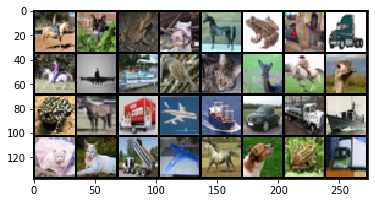

In [88]:
img_grid = torchvision.utils.make_grid(images)
plt.imshow(img_grid.permute(1,2,0).numpy().squeeze(), cmap='gray_r')

In [99]:
learning_rate = 0.001
epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet(input_size=input_size, hidden_size=3840, output_size=output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print('Optimization type: ',device)
print('Device name: ',torch.cuda.get_device_name(0))

Optimization type:  cuda
Device name:  Tesla V100-SXM2-32GB


In [100]:
for epoch in range(epochs):
  running_loss = 0.0
  if epoch>10:
    learning_rate = learning_rate*0.1
  for i, (images, labels) in enumerate(trainloader):
    if dataset=='mnist':
      images = images.view(images.shape[0],-1).to(device)
    else:
      images =images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss+= loss.item()
    if i%1000 == 999:
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 200))
      running_loss = 0.0
print('Finished Training')

[1,  1000] loss: 8.955
[2,  1000] loss: 6.500
[3,  1000] loss: 5.361
[4,  1000] loss: 4.731
[5,  1000] loss: 4.279
[6,  1000] loss: 3.963
[7,  1000] loss: 3.581
[8,  1000] loss: 3.324
[9,  1000] loss: 3.115
[10,  1000] loss: 2.901
[11,  1000] loss: 2.728
[12,  1000] loss: 2.523
[13,  1000] loss: 2.401
[14,  1000] loss: 2.184
[15,  1000] loss: 2.099
Finished Training


In [101]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    if dataset == 'mnist':
      images = images.view(images.shape[0],-1).to(device)
    else:
      images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct += (predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 77 %


This is not very good result.
HyperParameter tunning is necessary.